In [1]:
import pandas as pd
import jax.numpy as jnp

from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt
import seaborn as sns

from cartm.model import ContextTopicModel
from cartm.prepocessing import DatasetPreprocessor

This example will guide you through the basic interaction with the model.

First, let's download a sample dataset and preprocess it with `DatasetPreprocessor`.

In [10]:
data = fetch_20newsgroups(data_home='./data/', subset='all').data
print(f'Total number of documents in corpus: {len(data)}')
print(f'Total number of words in corpus: {sum([len(doc.split(' ')) for doc in data])}')

Total number of documents in corpus: 18846
Total number of words in corpus: 5937230


In [11]:
preprocessor = DatasetPreprocessor()
tokenized_data, document_bounds = preprocessor.fit_transform(data)
print(f'Total number of document boundaries in preprocessed corpus: {len(document_bounds)}')
print(f'Total number of tokenized words in preprocessed corpus: {len(tokenized_data)}')

Total number of document boundaries in preprocessed corpus: 18847
Total number of tokenized words in preprocessed corpus: 3450212


The `DatasetPreprocessor` class handles the filtering and tokenizing of the raw data. Its method `fit_transform` learns the vocabulary of the passed corpus of documents and returns tokenized words from corpus as the first return value, and document bounds as the second return value.

By default, `DatasetPreprocessor` removes stopwords, digits and special characters, therefore the total number of tokenized words is less than the number of words in raw corpus. Document boundaries are at the beginning and ending of the document, therefore the number of boundaries is [number_of_documents] + 1.

The returned values from `fit_transform` have jax.numpy.ndarray type, so you can work with them like a normal arrays.

In [13]:
print(f'Number of unique words in the preprocessed corpus: {jnp.max(tokenized_data)}')

Number of unique words in the preprocessed corpus: 107672


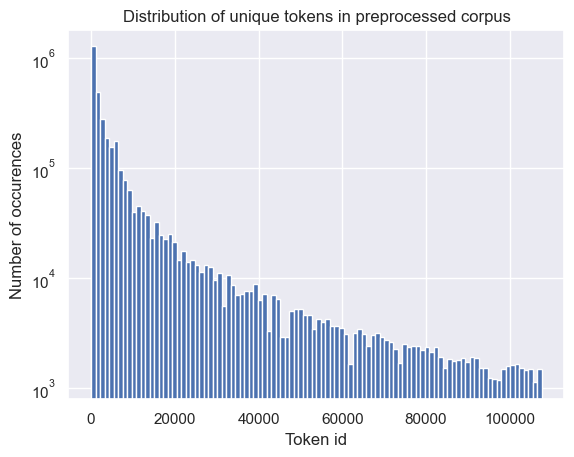

In [22]:
sns.set_theme()

plt.hist(tokenized_data, bins=100)

plt.xlabel('Token id')
plt.ylabel('Number of occurences')
plt.title('Distribution of unique tokens in preprocessed corpus')
plt.yscale('log')
plt.show()

You can also access mapping of words to tokens after fitting the preprocessor with data.

In [24]:
vocabulary = preprocessor.vocabulary

for i, (word, token) in enumerate(vocabulary.items()):
    print(f'{word}: {token}')
    if i == 10:
        break

mamatha: 0
devineni: 1
ratnam: 2
mr: 3
andrew: 4
cmu: 5
edu: 6
subject: 7
pen: 8
fan: 9
reaction: 10


Having the data preprocessed with `DatasetPreprocessor`, we can fit out model pretty straighforwardly.

In [31]:
topic_model = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
)

topic_model.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    verbose=2,
)

Iteration [1/1000], phi update diff norm: 0.1312
Iteration [2/1000], phi update diff norm: 0.0245
Iteration [3/1000], phi update diff norm: 0.0294
Iteration [4/1000], phi update diff norm: 0.0341
Iteration [5/1000], phi update diff norm: 0.0440
Iteration [6/1000], phi update diff norm: 0.0610
Iteration [7/1000], phi update diff norm: 0.0668
Iteration [8/1000], phi update diff norm: 0.0636
Iteration [9/1000], phi update diff norm: 0.0673
Iteration [10/1000], phi update diff norm: 0.0618
Iteration [11/1000], phi update diff norm: 0.0411
Iteration [12/1000], phi update diff norm: 0.0215
Iteration [13/1000], phi update diff norm: 0.0148
Iteration [14/1000], phi update diff norm: 0.0149
Iteration [15/1000], phi update diff norm: 0.0177
Iteration [16/1000], phi update diff norm: 0.0238
Iteration [17/1000], phi update diff norm: 0.0295
Iteration [18/1000], phi update diff norm: 0.0218
Iteration [19/1000], phi update diff norm: 0.0109
Iteration [20/1000], phi update diff norm: 0.0087
Iteration

The model stops fitting because the update diff norm becomes too low. This means that the model has converged. You can modify the convergence threshold and max number of iterations.

In [ ]:
topic_model_tol = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
)

topic_model_tol.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    tol=0.01,
    verbose=2,
)

Iteration [1/1000], phi update diff norm: 0.1312
Iteration [2/1000], phi update diff norm: 0.0245
Iteration [3/1000], phi update diff norm: 0.0294
Iteration [4/1000], phi update diff norm: 0.0341
Iteration [5/1000], phi update diff norm: 0.0440
Iteration [6/1000], phi update diff norm: 0.0610
Iteration [7/1000], phi update diff norm: 0.0668
Iteration [8/1000], phi update diff norm: 0.0636
Iteration [9/1000], phi update diff norm: 0.0673
Iteration [10/1000], phi update diff norm: 0.0618
Iteration [11/1000], phi update diff norm: 0.0411
Iteration [12/1000], phi update diff norm: 0.0215
Iteration [13/1000], phi update diff norm: 0.0148
Iteration [14/1000], phi update diff norm: 0.0149
Iteration [15/1000], phi update diff norm: 0.0177
Iteration [16/1000], phi update diff norm: 0.0238
Iteration [17/1000], phi update diff norm: 0.0295
Iteration [18/1000], phi update diff norm: 0.0218
Iteration [19/1000], phi update diff norm: 0.0109
Iteration [20/1000], phi update diff norm: 0.0087


In [30]:
topic_model_iter = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
)

topic_model_iter.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    max_iter=10,
    verbose=2,
)

Iteration [1/10], phi update diff norm: 0.1312
Iteration [2/10], phi update diff norm: 0.0245
Iteration [3/10], phi update diff norm: 0.0294
Iteration [4/10], phi update diff norm: 0.0341
Iteration [5/10], phi update diff norm: 0.0440
Iteration [6/10], phi update diff norm: 0.0610
Iteration [7/10], phi update diff norm: 0.0668
Iteration [8/10], phi update diff norm: 0.0636
Iteration [9/10], phi update diff norm: 0.0673
Iteration [10/10], phi update diff norm: 0.0618


You can also modify number of topics and other parameters of the model. Refer to the `fit` funciton docs for more info on fitting the model.

After the model is fitted, you can access its parameters and analyse them.

In [32]:
phi_wt = topic_model.phi  # p(w|t)
n_t = topic_model.n_t  # denormalized distribution of topics
print(f'phi matrix type: {type(phi_wt)}, shape: {phi_wt.shape}')
print(f'n_t array type: {type(n_t)}, shape: {n_t.shape}')

phi matrix type: <class 'jaxlib.xla_extension.ArrayImpl'>, shape: (107673, 10)
n_t array type: <class 'jaxlib.xla_extension.ArrayImpl'>, shape: (10,)


Plot a histogram of a distribution of topics in corpus:

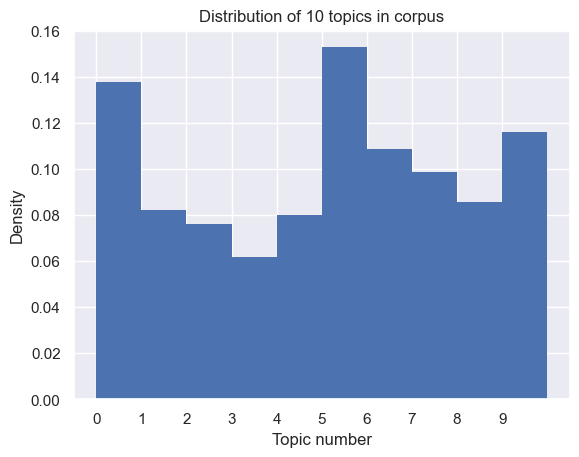

In [48]:
plt.stairs(n_t / n_t.sum(), range(len(n_t) + 1), fill=True)

plt.xticks(range(len(n_t)))
plt.xlabel('Topic number')
plt.ylabel('Density')
plt.title('Distribution of 10 topics in corpus')
plt.show()

Print top-10 words from each topic:

In [53]:
# find top-10 words with the biggest probability p(w|t) for each topic t
topk = jnp.argsort(phi_wt, axis=0, descending=True)[:10, :].T

# create mapping token -> word from existing mapping word -> token (vocabulary)
reverse_vocab = {value: key for key, value in vocabulary.items()}

for topic_idx, t in enumerate(topk):
    print(f'Topic {topic_idx + 1}:', '\t'.join([reverse_vocab[int(idx)] for idx in t]))
    print()

Topic 1: would	know	one	like	doe	ha	think	make	thing	could

Topic 2: line	organization	article	university	apr	ca	edu	distribution	c	usa

Topic 3: x	file	window	program	mail	available	please	image	ftp	list

Topic 4: ax	edu	posting	host	nntp	max	cc	c	mit	writes

Topic 5: com	subject	writes	uk	ac	edu	david	john	thanks	reply

Topic 6: wa	people	god	u	government	ha	law	right	christian	state

Topic 7: year	wa	time	day	last	space	two	ha	first	ago

Topic 8: new	system	drive	use	bit	card	chip	key	data	disk

Topic 9: w	r	g	p	f	b	q	v	c	u

Topic 10: wa	would	go	get	time	one	people	game	back	first

